# Группа: DST-48
**Sergey Pinaev - binom1982@gmail.com**
# Финальный проект 
Предсказание стоимости домов, основываясь на истории предложений.  

Ссылка на соревнование: [[SF-DST] Car Price prediction](https://www.kaggle.com/c/sf-dst-car-price-prediction-part2)

<p align="center" width="100%">
<img src="https://habrastorage.org/r/w1560/getpro/habr/upload_files/080/2a6/5e7/0802a65e78ee2bd84388c0d1ebab98d5.png" width="auto"/>
</p>
<hr>

## Task

Ко мне обратился представитель крупного агентства недвижимости со следующей проблемой:

Мои риелторы тратят катастрофически много времени на сортировку объявлений и поиск выгодных предложений. Поэтому их скорость реакции, да и, сказать по правде, качество анализа не дотягивает до уровня конкурентов. А это сказывается на наших финансовых показателях. Твоя задача — разработать модель, которая бы позволила обойти конкурентов по скорости и качеству совершения сделок. Датасет прикладываю.

**Цель**: разработать сервис, который будет предсказывать стоимость домов, основываясь на истории предложений.

## Data Description:

В датасете 18 колонок

Целевая переменная **target** - цена объекта недвижимости
* **status** - статус объявления
* **private pool** - наличие бассейна, вероятно дублируется столбцом **PrivatePool**
* **propertyType** - тип объекта недвижимости
* **street**- адрес
* **baths** - количество ванных комнат
* **homeFacts**- информация о доме. Этот столбец надо парсить
* **fireplace** - наличие камина
* **city** - город
* **schools** - рейтинг и близость образовательных учреждений. Нужно парсить
* **sqft** - площадь в квадратных футах
* **zipcode** - почтовый индекс
* **beds**- количество спальен (или количество кроватей) 
* **state** - штат
* **stories** - вероятно, количество владельцев или продаж этого дома
* **mls-id** - идентификационный номер в системе MLS. Вероятно, дополняется столбцом **MlsId**


## Libraries

In [147]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import random
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import sys
import PIL
import cv2
import re
import json

# import datetime, time
from datetime import timedelta, datetime, date, time

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

# import xgboost as xgb
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import StackingRegressor
from catboost import CatBoostRegressor

from sklearn.linear_model import LinearRegression, LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.feature_selection import RFE # Рекурсивное устранение признаков (RFE)
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error

# # keras
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import albumentations

# plt
import matplotlib.pyplot as plt
import seaborn as sns
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline
plt.style.use('fivethirtyeight')
# Подключаем форматирование Markdown
from IPython.display import Markdown

print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)
print('Keras        :', tf.keras.__version__)

# Чтобы вычисления проходили на GPU необходимо чтобы tensorflow определил GPU.
# Как это сделать практически без боли написано здесь https://artificialintelligence.so/forums/discussion/how-to-install-tensorflow/
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
tf.config.list_physical_devices()
# Подключим видеокарту
!nvidia-smi -L
# !pip freeze > requirements.txt

Python       : 3.8.12 (default, Oct 12 2021, 03:01:40) [MSC v.1916 64 bit (AMD64)]
Numpy        : 1.19.5
Tensorflow   : 2.5.0
Keras        : 2.5.0
Num GPUs Available:  1
GPU 0: NVIDIA GeForce RTX 2070 SUPER (UUID: GPU-f6280479-d16b-33b8-dd70-6511eca96aa8)


In [148]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
isWorking = False # флаг для запуска кода

## Functions

In [149]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))


def get_other_values(series, percentile=90):
    '''
    Возвращает список значений ниже определенного порога, которые необходимо переменовать
    '''
    value_counts = series.value_counts()
    # Найдем значения описывающие percentile всех значений
    top_values = int(np.percentile(series.value_counts(dropna=False), percentile))
    # Оставим только percentile значений
    other = value_counts[value_counts < top_values].index
#     display(other)
    return other

def get_emission_limits(data_series):
    '''
    Возвращает кортеж границ выбросов вычесленных на основе межвартильного размаха и 1 и 99 перцентиль.
    При необходимости данные выходящие за нижнюю и верхнюю границу можно не удалять а присваивать им значение  1 и 99 перцентиля.
    df.loc[df['column'] < min_emission_limits, 'column'] = perc01
    df.loc[df['column'] > max_emission_limits, 'column'] = perc99
    '''
    perc25, perc75 = np.percentile(data_series,[25,75])
    perc1, perc99 = np.percentile(data_series,[1,99])
    # perc0, perc100 = np.percentile(data_series,[0,100])
    # print(perc0, perc100) # Иногда выбросы меньше/больше min/max значений так что можно было бы доработать
    
    IQR = perc75 - perc25
    min_emission_limits = perc25 - 1.5*IQR
    max_emission_limits = perc75 + 1.5*IQR

    '''Выводит распределение данных для каждого столбца в датасете'''
    l = ['| P1 | Min emission | P25 | IQR | P75 | Max emission | P99 |',
         '|-----|:-----:|----|-----|----|:-----:|-----|',
        f'|{perc1}|{min_emission_limits}|{perc25}|{IQR}|{perc75}|{max_emission_limits}|{perc99}|']
            
    display(Markdown('\n'.join(l)))
    return perc1, min_emission_limits, max_emission_limits, perc99


def get_boxplot(dataset, column, value, axes, kind=True):
    '''Отображет boxplot'''
    #fig, axes = plt.subplots(figsize=(10, 4))
    
    if kind:
        sns.boxplot(x=column, y=value, data=dataset, ax=axes)
    else:
        sns.violinplot(x=column, y=value, data=dataset, ax=axes)
    # plt.xticks(rotation=45)
    # ax.set_title('Boxplot for ' + column)
    # plt.show()
    
    
def myround(x, prec=2, base=.05):
    return round(base * round(float(x)/base), prec)



## Loading data

In [150]:
PATH = "G:/Datasets/finale_project/data.csv/data.csv"
data = pd.read_csv(PATH)

In [151]:
data.columns = data.columns.map(lambda x: x.replace(' ', '_').replace('-', '_'))
display(data.head(4).T)

,0,1,2,3
status,Active,for sale,for sale,for sale
private_pool,NaN,NaN,NaN,NaN
propertyType,Single Family Home,single-family home,single-family home,single-family home
street,240 Heather Ln,12911 E Heroy Ave,2005 Westridge Rd,4311 Livingston Ave
baths,3.5,3 Baths,2 Baths,8 Baths
homeFacts,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...","{'atAGlanceFacts': [{'factValue': '2019', 'fac...","{'atAGlanceFacts': [{'factValue': '1961', 'fac...","{'atAGlanceFacts': [{'factValue': '2006', 'fac..."
fireplace,Gas Logs,NaN,yes,yes
city,Southern Pines,Spokane Valley,Los Angeles,Dallas
schools,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...","[{'rating': ['4/10', 'None/10', '4/10'], 'data...","[{'rating': ['8/10', '4/10', '8/10'], 'data': ...","[{'rating': ['9/10', '9/10', '10/10', '9/10'],..."
sqft,2900,"1,947 sqft","3,000 sqft","6,457 sqft"


In [152]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377185 entries, 0 to 377184
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   status        337267 non-null  object
 1   private_pool  4181 non-null    object
 2   propertyType  342452 non-null  object
 3   street        377183 non-null  object
 4   baths         270847 non-null  object
 5   homeFacts     377185 non-null  object
 6   fireplace     103115 non-null  object
 7   city          377151 non-null  object
 8   schools       377185 non-null  object
 9   sqft          336608 non-null  object
 10  zipcode       377185 non-null  object
 11  beds          285903 non-null  object
 12  state         377185 non-null  object
 13  stories       226470 non-null  object
 14  mls_id        24942 non-null   object
 15  PrivatePool   40311 non-null   object
 16  MlsId         310305 non-null  object
 17  target        374704 non-null  object
dtypes: object(18)
memory usa

In [153]:
data.describe()

,status,private_pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls_id,PrivatePool,MlsId,target
count,337267,4181,342452,377183,270847,377185,103115,377151,377185,336608,377185,285903,377185,226470,24942,40311,310305,374704
unique,159,1,1280,337076,229,321009,1653,2026,297365,25405,4549,1184,39,348,24907,2,232944,43939
top,for sale,Yes,single-family home,Address Not Disclosed,2 Baths,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",yes,Houston,"[{'rating': [], 'data': {'Distance': [], 'Grad...",0,32137,3 Beds,FL,1.0,No MLS#,yes,NO MLS,"$225,000"
freq,156104,4181,92206,672,52466,7174,50356,24442,4204,11854,2141,53459,115449,67454,3,28793,24,1462


## EDA

In [154]:
# список столбцов для удаления
delete_col = []

### Columns "mls_id" and "MlsId"

In [155]:
# Начнем с удаления дубликатов в столбцах в названиях которых присутвует "id". 
print('Пропуски:', data.mls_id.isna().sum())
print('Уникальных:', data.target.nunique())

MlsId =  data.MlsId.value_counts(dropna=False)
MlsId[MlsId >= 2]

Пропуски: 352243
Уникальных: 43939


NaN                        66880
NO MLS                        24
No MLS #                      16
 A, Houston, TX 77008         13
 12A, Orlando, FL 32833       11
                           ...  
4139661                        2
72578274                       2
3564047                        2
14228422                       2
58868465                       2
Name: MlsId, Length: 61272, dtype: int64

In [156]:
display(data[data.MlsId == '58868465'])

,status,private_pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls_id,PrivatePool,MlsId,target
4215,for sale,NaN,single-family home,415 Isolde Dr,5 Baths,"{'atAGlanceFacts': [{'factValue': '2012', 'fac...",yes,Houston,"[{'rating': ['10/10', '8/10', '10/10'], 'data'...","3,991 sqft",77024,4 Beds,TX,2.0,NaN,NaN,58868465,"$1,050,000"
106792,NaN,NaN,Single Family,415 Isolde Dr,5,"{'atAGlanceFacts': [{'factValue': '2012', 'fac...",NaN,Houston,"[{'rating': ['10/10', '10/10', '8/10'], 'data'...","3,991",77024,4,TX,2.0,NaN,NaN,58868465,"$1,050,000"


По самому частому 'MlsId' 6 записей по 3 в SAN ANTONIO и SEATTLE.
Данные дублируют друг друга. Желательно удалить строки дубликатов.

В них больше всего пропусков, соответственно, поэтому дополнение датасета данными из другой базы данных, 
например американской базы риелторов по этим id, представляется нецелесообразным, 
так как датасет будет дополнен неравномерно.

In [157]:
# TODO Пока удалим столбец (по этому столбцу позже можно удалить дубли)
delete_col.append("MlsId")
delete_col.append("mls_id")


In [158]:
# # Визуализируем пропуски:
# fig, ax = plt.subplots(figsize=(15,10))
# sns_heatmap=sns.heatmap(data.isnull(), yticklabels=False, cbar=False, cmap= 'coolwarm')

### Column "status"

In [159]:
print('Пропуски:', data.status.isna().sum())
print('Уникальных:', data.status.nunique())

data.status = data.status.str.upper()
display(data.status.value_counts(dropna=False)[:20])

Пропуски: 39918
Уникальных: 159


FOR SALE                     199571
ACTIVE                       105207
NaN                           39918
FORECLOSURE                    6769
NEW CONSTRUCTION               5475
PENDING                        4807
PRE-FORECLOSURE                2119
PRE-FORECLOSURE / AUCTION      1560
P                              1488
UNDER CONTRACT SHOW            1183
 / AUCTION                      936
UNDER CONTRACT   SHOWING        793
ACTIVE UNDER CONTRACT           718
UNDER CONTRACT                  692
NEW                             690
CONTINGENT                      581
PRICE CHANGE                    563
AUCTION                         536
FORECLOSED                      459
A ACTIVE                        443
Name: status, dtype: int64

Больше 250.000 записей о продаже готовой недвижимости **ACTIVE**, **FOR SALE**,
**NaN** значений около 40.000.

Много записей о :
* строящемся жилье **PENDING** 
* о выкупе у должников **FORECLOUSER**
* отдельно указываются новостройки **NEW CONSTRUCTION**.
 
Не очень понятна принципиальная разница между категориями 'ACTIVE' и 'FOR SALE'. Они по сути отражают одно и то же сотояние объекта недвижимоти - готовность объекта к продаже(активное объявление). 

Насчет заполнения пропусков. Раз они присутствуют в датасете - они должны быть активными и готовыми к продаже, как и абсолютное большинство других объявлений.

In [160]:
def parse_status(value):
    if type(value)==str:
        s = str(value)
        if 'AUCTION' in s: return 'AUCTION'
        if 'COMIN' in s or 'DILIGE' in s: return 'COMING'
        if 'RENT' in s: return 'RENT'
        if 'LEASE' in s: return 'RENT'
        if 'PURCH' in s: return 'RENT'
        if 'PEND' in s: return 'PENDING'
        if 'FOREC' in s: return 'FORECLOSURE'
        if 'NEW' in s: return 'NEW'
        if 'CONTRACT' in s: return 'CONTRACT'
        if 'CONTINGE' in s: return 'CONTINGENT'
        if 'SOLD' in s or 'CLOSED' in s or 'ACCEPT' in s: return 'SOLD'
        if 'ACTIV' in s: return 'ACTIVE'
        if 'FOR SALE' in s: return 'FOR SALE'
        if 'BACKUP' in s: return 'CONTRACT'
        if 'BACK' in s or 'EXTEND' in s: return 'ACTIVE'
        if 'CONTINUE' in s: return 'ACTIVE'
        if s == 'C' or  s == 'CT': return 'CONTRACT'
        if s == 'P': return 'PENDING'
        if s == 'PS' or s == 'PF' or s == 'PI': return 'PENDING'
       
        else: return s
    else:
         # if s == 'nan' : return  "NO_DATA" # 'ACTIVE'
        return "NO_DATA"

In [161]:
status = data.status.map(parse_status)
display(status.value_counts(dropna=False))
data.status = status.astype("category")
# data.status.hist(figsize=(15,5), log=False, bins=50, xrot=90);
# plt.tight_layout()

FOR SALE        199571
ACTIVE          105909
NO_DATA          39918
FORECLOSURE       9349
PENDING           6891
NEW               6165
CONTRACT          3848
AUCTION           3070
CONTINGENT        1027
PRICE CHANGE       563
RENT               424
SOLD               313
COMING             137
Name: status, dtype: int64

In [162]:
# Видно, что для объявления о сдаче недвижимости в аренду, цена считается за месяц и в стоимости присутствует
# приписка о помесячной оплате '/mo'. 
# Наш датасет должен содеражть данные о продаже жилья, а сдача жилья это уже для другой задачи. 
# Поэтому удалим удалим 424 записи со статусом 'RENT'.
data[data.status == 'RENT']['target'][:8]

# Удаляем записи
data = data[data.status != 'RENT']

### Columns "private pool" and "PrivatePool"

In [163]:
# private_pool
print('Пропуски:', data.private_pool.isna().sum())
print('Уникальных:', data.private_pool.nunique())
data.private_pool = data.private_pool.str.upper()

display(data.private_pool.value_counts(dropna=False))
data.private_pool.fillna(0, inplace=True)
data.private_pool = data.private_pool.apply(lambda x: 1 if x == 'YES' else 0).astype('bool')
display(data.private_pool.value_counts(dropna=False))

# Данные о бассеинах не пересекаются

Пропуски: 372580
Уникальных: 1


NaN    372580
YES      4181
Name: private_pool, dtype: int64

False    372580
True       4181
Name: private_pool, dtype: int64

In [164]:
# PrivatePool
print('Пропуски:', data.PrivatePool.isna().sum())
print('Уникальных:', data.PrivatePool.nunique())
data.PrivatePool = data.PrivatePool.str.upper()

display(data.PrivatePool.value_counts(dropna=False))
# data.PrivatePool = data.PrivatePool.apply(lambda x: x if type(x)!=str else x.lower())
data.PrivatePool.fillna(0, inplace=True)
data.PrivatePool = data.PrivatePool.apply(lambda x: 1 if x == 'YES' else 0).astype('bool')
display(data.PrivatePool.value_counts(dropna=False))

Пропуски: 336547
Уникальных: 2


NaN    336547
YES     40214
Name: PrivatePool, dtype: int64

False    336547
True      40214
Name: PrivatePool, dtype: int64

Данные из столбцов не пересекаются.
Заполним NaN нулями, заменим 'Yes' и 'yes' на единицы и объединим эти два столбца

In [165]:
# TODO Я пока не могу понять почему эти данные не пересекаются, тут чтото не так!
data['private_pool_union'] = False
data.loc[data['private_pool'], 'private_pool_union'] = True
data.loc[data['PrivatePool'], 'private_pool_union'] = True
display(data.private_pool_union.value_counts(dropna=False))

False    332366
True      44395
Name: private_pool_union, dtype: int64

In [166]:
# TODO Пока удалим столбец (по этому столбцу позже можно удалить дубли)
delete_col.append('private_pool')
delete_col.append('PrivatePool')

### Column "propertyType"

In [167]:
print('Пропуски:', data.propertyType.isna().sum())
print('Уникальных:', data.propertyType.nunique())
data.propertyType = data.propertyType.str.upper()
display(data.propertyType.value_counts(dropna=False))

# propertyType = data.propertyType.apply(lambda x: x if type(x)!=str else x.replace(' ', '').replace('-', ''))
# propertyType = propertyType.apply(lambda x: x if type(x)!=str else x.replace('singlefamilyhome', 'singlefamily'))

# display(propertyType.value_counts(dropna=False))
# Имеем 1280 описаний типа недвижимости. Надо разбить на разумное число категорий.

Пропуски: 34733
Уникальных: 1280


SINGLE-FAMILY HOME                                             91989
SINGLE FAMILY                                                  62869
CONDO                                                          42522
NaN                                                            34733
SINGLE FAMILY HOME                                             31717
                                                               ...  
CUSTOM, ELEVATED, OTHER                                            1
CONTEMPORARY, FARMHOUSE                                            1
2 STORIES, TRADITIONAL, MEDITERRANEAN, TEXAS HILL COUNTRY          1
1 STORY, CONTEMPORARY, TRADITIONAL, MEDITERRANEAN                  1
BILEVEL, CONVERTED DWELLING, LOFT WITH BEDROOMS, CONDO/UNIT        1
Name: propertyType, Length: 1273, dtype: int64

In [168]:
def parse_property_type(s):
    s = str(s)
    if 'SINGLE' in s or 'TRADITIONAL' in s: return 'SINGLE'
    if 'CONDO' in s or 'FLAT' in s: return 'FLAT'
    if 'TOWNH' in s: return 'TOWNHOUSE'
    if 'COOP' in s or 'CO-OP' in s: return 'COOP'
    if 'LAND' in s: return 'LAND'
    if 'MULTI' in s: return 'MULTI'
    if 'CONTEMPO' in s: return 'CONTEMPORARY'
    if 'MOBI' in s or 'CARRI' in s: return 'MOBILE'
    if 'TWO STOR' in s or '2 STOR' in s: return 'TWO-STORY'
    if 'ONE STOR' in s or '1 STOR' in s: return 'ONE-STORY'
    if 'STOR' in s in s: return 'MULTY-STORY'
    if 'DETA' in s or 'DETA' in s: return 'DETACHED'
    # if 'MID' in s or '5-9' in s  or '4' in s or '3' in s: return 'MID-RISE'
    # if 'LOW' in s: return 'LOW-RISE'
    # if 'HIGH' in s or 'UNIT' in s: return 'HIGH-RISE'
    if 'RISE' in s or 'UNIT' in s or 'HIGH' in s: return 'FLAT'
    if 'PENT' in s: return 'PENTHOUSE'
    if 'RAN' in s: return 'RANCH'
    if 'GARD' in s: return 'GARDEN HOME'
    if 'CUST' in s or 'MANUF' in s or 'CRAFT' in s: return 'CUSTOM'
    if 'ATTA' in s or 'PLEX' in s: return 'ATTACHED'
    if 'FARM' in s: return 'FARM'
    if 'LEVEL' in s: return 'SPLIT-LEVEL'
    if 'OTHER' in s: return 'OTHER'
    if 'COLO' in s: return 'COLONIAL'
    if 'WARE' in s or 'COM' in s: return 'COMMERCICAL'
    if 'COTT' in s or 'RESID' in s or 'COURT' in s: return 'COTTAGE'
    if 'BOAT' in s: return 'BOATHOUSE'

    if s == 'nan' or s == '': 
        return 'SINGLE'

    else:
         return 'OTHER'

In [169]:
data.propertyType = data.propertyType = data.propertyType.map(parse_property_type).astype('category')
display(data.propertyType.value_counts(dropna=False))

# data.propertyType.hist(figsize=(15,5), log=False, bins=200, xrot=90, orientation="vertical");
# plt.tight_layout()

SINGLE          232829
FLAT             53010
LAND             31494
TOWNHOUSE        18528
MULTI            12365
OTHER             4420
ONE-STORY         4009
COOP              3840
MOBILE            3521
RANCH             3475
CONTEMPORARY      3383
TWO-STORY         2505
COLONIAL          1257
CUSTOM             477
GARDEN HOME        358
SPLIT-LEVEL        345
MULTY-STORY        230
COTTAGE            199
ATTACHED           179
DETACHED           157
PENTHOUSE           79
FARM                78
COMMERCICAL         19
BOATHOUSE            4
Name: propertyType, dtype: int64

In [170]:
#mask = (data.propertyType != 'FARM') #and (data.propertyType != 'COMMERCICAL') and (data.propertyType != 'BOATHOUSE')
mask = ~data.propertyType.isin(['FARM', 'COMMERCICAL', 'BOATHOUSE'])
data = data[mask]
display(data.propertyType.value_counts(dropna=False))
# propertyType.propertyType[~mask]

SINGLE          232829
FLAT             53010
LAND             31494
TOWNHOUSE        18528
MULTI            12365
OTHER             4420
ONE-STORY         4009
COOP              3840
MOBILE            3521
RANCH             3475
CONTEMPORARY      3383
TWO-STORY         2505
COLONIAL          1257
CUSTOM             477
GARDEN HOME        358
SPLIT-LEVEL        345
MULTY-STORY        230
COTTAGE            199
ATTACHED           179
DETACHED           157
PENTHOUSE           79
BOATHOUSE            0
FARM                 0
COMMERCICAL          0
Name: propertyType, dtype: int64

### Column "street"

In [171]:
print('Пропуски:', data.street.isna().sum())
print('Уникальных:', data.street.nunique())
data.street = data.street.str.upper()
display(data.street.value_counts(dropna=False))

Пропуски: 2
Уникальных: 336646


ADDRESS NOT DISCLOSED    672
UNDISCLOSED ADDRESS      516
(UNDISCLOSED ADDRESS)    391
ADDRESS NOT AVAILABLE    175
UNKNOWN ADDRESS           72
                        ... 
2664 ROSEBUD LN            1
8246 SHARONDALE DR         1
3739 NE 165TH ST           1
6101 SW 106TH ST           1
5983 MIDCROWN DR           1
Name: street, Length: 335837, dtype: int64

Более 336 тысяч уникальных адресов. 
Возможно можно было бы извлечь из адресов геолокацию, для определения новых признаков таких как район, центр и тд. и посчитать для них среднюю или медианную цену. Но пока времени на это нет, если останется то попробую.

Почти в каждом адресе есть аббревиатуры типа улицы, например 'BLVD' -бульвар, 'ROAD' - дорога и т.п. а также номер дома.

Попробую из столбца 'street' сделать категориальный признак с типом улицы.   

In [172]:
def parse_street(s):
    s = str(s)
    if 'ADDRESS' in s: return 'NO_ADDRESS'
    elif 'BLVD' in s or 'BOULEVARD' in s: return 'BOULEVARD'
    elif 'WAY' in s: return 'HWAY'
    elif 'CIR' in s: return 'CIRCLE'
    elif 'CT' in s or 'COURT' in s: return 'COURT'
    elif 'DR' in s or 'DRIVE' in s: return 'DRIVE'
    elif 'RD' in s or 'ROAD' in s: return 'ROAD'
    elif 'AVE' in s: return 'AVENUE'
    elif 'ST' in s or 'STREET' in s: return 'STREET'
    elif 'PL' in s: return 'PLACE'
    elif 'LANE' in s: return 'LANE'
    elif 'TR' in s or 'TRL' in s or 'TRAIL' in s: return 'TRAIL'
    elif 'PARK' in s: return 'PARK'
    else: return 'OTHER'

STREET        86010
DRIVE         65544
AVENUE        60611
OTHER         43779
ROAD          43198
COURT         19993
PLACE         15291
BOULEVARD     13616
HWAY          12537
CIRCLE         8821
TRAIL          4342
NO_ADDRESS     1834
PARK            745
LANE            339
Name: street_type, dtype: int64

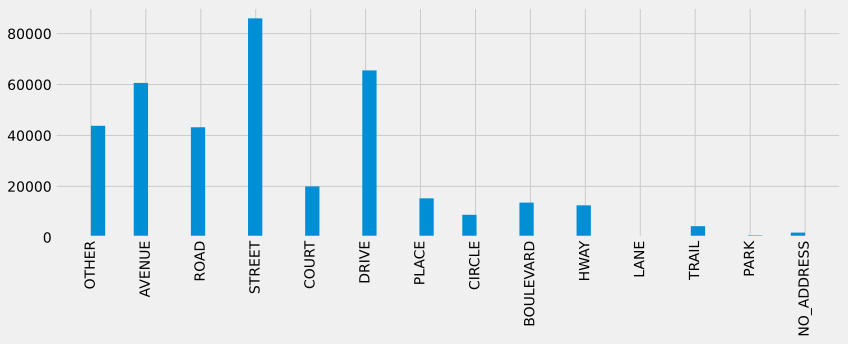

In [173]:
data['street_type'] = data.street.map(parse_street).astype('category')
# TODO: Позже можно попробовать добавить новые признаки с средней/медианной ценой

display(data.street_type.value_counts(dropna=False))
data.street_type.hist(figsize=(12,5), log=False, bins=50, xrot=90);
plt.tight_layout()

# Удалим street
delete_col.append('street')

In [174]:
# plt.figure(figsize=(12,5))
# ax = sns.boxplot(x="street_type", y="target_log", data=data);
# ax.set_xticklabels(ax.get_xticklabels(),rotation=90);

In [175]:
# Создадим признак наличия адреса
data['has_address'] =  data.street_type.apply(lambda x: False if x == 'NO_ADDRESS' else True).astype(bool)
display(data.has_address.value_counts(dropna=False))

# Признак has_address практически не влияет на цену, но пока оставим
# plt.figure(figsize=(12,5))
# ax = sns.boxplot(x="has_address", y="target_log", data=data);
# ax.set_xticklabels(ax.get_xticklabels(),rotation=90);

True     374826
False      1834
Name: has_address, dtype: int64

In [176]:
delete_col.append('street')

### Column "baths"

In [177]:
print('Пропуски:', data.baths.isna().sum())
print('Уникальных:', data.baths.nunique())
data.baths = data.baths.str.upper()
display(data.baths.value_counts(dropna=False))

Пропуски: 106171
Уникальных: 228


NaN           106171
2 BATHS        52344
3 BATHS        35468
2              20450
2.0            16576
               ...  
4.75 BATHS         1
5.25 BATHS         1
41.0               1
1.8 BATHS          1
44.0               1
Name: baths, Length: 227, dtype: int64

У более чем 100000 записей нет информации о наличии ванной комнаты (TODO нужно подумать как быть)!
Оказывается, что бывают ванны (https://www.realtor.com/advice/buy/what-is-a-half-bath/):
* 1.0 полноценная - должна содержать четыре основных приспособления: унитаз, раковину, ванну и душ (или комбинацию душа и ванны).
* 0.5 полуванна - имеет только два из четырех основных компонентов ванной комнаты, обычно унитаз и раковину
* 0.75 трехчетвертная ванна - в ней не хватает одного из четырех перечисленных выше приспособлений. Чаще всего это будет ванна.
* 0.25 четверть ванна - комната только с одним из четырех элементов, обычно это туалет

Если в доме указано, что в нем три ванные комнаты и две полуванные, почему бы просто не сложить их все вместе и не сказать, что ванных комнат четыре? Это казалось бы логичным, но каждая ванная комната должна быть указана отдельно, потому что это дает покупателям жилья лучшее представление об особенностях дома и их возможностях, когда им просто нужно уйти.

In [178]:
def parse_baths(s):
    s = str(s)
    if s == '0': return 0.0
    if s == '': return 1.0
    if s == 'nan': return 1.0
    if 'SQ. FT.' in s: return 1.0
    if '-' in s or '—' in s or '~' in s: return 0.0
    if 'SEMIMOD' in s: return 1.0
    #if '/' in s: print(s)

    s = s.replace(',', '.')
    f = re.findall(r'\d*\.\d+|\d+', s)
    try:
        n = float(f[0])
        if n >= 200:
            n = n / 1000.
        return n
    except:
        print(s)
  
    return 1.0

In [179]:
baths = data.baths.map(parse_baths)#.astype('category')
# TODO: Нужно дополнительно обработать!

display(baths.value_counts(dropna=False))
data.baths = baths.round(1)
display(data.baths.value_counts(dropna=False))
# data.baths.hist(figsize=(12,5), log=False, bins=50, xrot=90);
# plt.tight_layout()

1.000      124154
2.000      103384
3.000       66633
4.000       26316
2.500       13722
            ...  
5.200           1
116.000         1
35.000          1
0.241           1
68.000          1
Name: baths, Length: 83, dtype: int64

1.0     124154
2.0     103384
3.0      66633
4.0      26316
2.5      13722
         ...  
0.5          1
3.3          1
43.0         1
25.0         1
68.0         1
Name: baths, Length: 78, dtype: int64

In [180]:
perc1, min_emission_limits, max_emission_limits, perc99 = get_emission_limits(data.baths)

data.baths.loc[data.baths < min_emission_limits] = 0 #int(perc1)
data.baths.loc[data.baths > max_emission_limits] = int(perc99)

| P1 | Min emission | P25 | IQR | P75 | Max emission | P99 |
|-----|:-----:|----|-----|----|:-----:|-----|
|0.0|-2.0|1.0|2.0|3.0|6.0|7.0|

C:\Users\binom\anaconda3\envs\tensorflow_25\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [181]:
# Заменим выбросы минимальным значением 0 и максимальным 99 перцентилем
perc1, min_emission_limits, max_emission_limits, perc99 = get_emission_limits(data.baths)
display(data.baths.value_counts(dropna=False))

| P1 | Min emission | P25 | IQR | P75 | Max emission | P99 |
|-----|:-----:|----|-----|----|:-----:|-----|
|0.0|-2.0|1.0|2.0|3.0|6.0|7.0|

1.0    124154
2.0    103384
3.0     66633
4.0     26316
2.5     13722
5.0      9451
3.5      6123
0.0      5216
7.0      5111
1.5      4336
6.0      4302
1.8      1809
4.5      1552
2.2      1460
1.2      1216
2.8      1001
5.5       521
0.8       239
2.1        53
1.1        17
3.2        13
3.1        12
3.8         8
4.1         3
5.2         2
4.2         2
0.2         1
3.3         1
0.5         1
4.8         1
Name: baths, dtype: int64

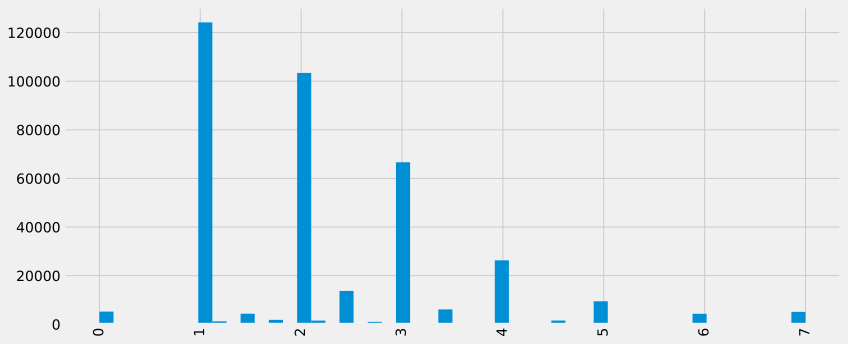

In [182]:
data.baths.hist(figsize=(12,5), log=False, bins=50, xrot=90);
plt.tight_layout()
# data.info()

### Column "homeFacts"

In [183]:
print('Пропуски:', data.homeFacts.isna().sum())
print('Уникальных:', data.homeFacts.nunique())
# display(data.homeFacts.value_counts(dropna=False))
data.homeFacts[0]

Пропуски: 0
Уникальных: 320673


"{'atAGlanceFacts': [{'factValue': '2019', 'factLabel': 'Year built'}, {'factValue': '', 'factLabel': 'Remodeled year'}, {'factValue': 'Central A/C, Heat Pump', 'factLabel': 'Heating'}, {'factValue': '', 'factLabel': 'Cooling'}, {'factValue': '', 'factLabel': 'Parking'}, {'factValue': None, 'factLabel': 'lotsize'}, {'factValue': '$144', 'factLabel': 'Price/sqft'}]}"

In [184]:
def clen(str):
  str = str.replace("''", '0')
  str = str.replace("'", "")
  str = str.replace("None", '0')
  str = str.replace("No Data", '0')
  str = str.replace("No Info", '0')
  str = str.replace("/sqft", '')
  str = str.replace("$", '')
  return str

In [185]:
def parse_home_facts(s):
  res = []
  s = s.split("{'atAGlanceFacts': [{'factValue': ")[1]
  s = s.split(", 'factLabel': 'Year built'}, {'factValue': ")
  s[0] = clen(s[0])
  # year = s[0]
  res.append(s[0])
  s = s[1].split(", 'factLabel': 'Remodeled year'}, {'factValue': ")
  s[0] = clen(s[0])
  # remo = s[0]
  res.append(s[0])
  s = s[1].split(", 'factLabel': 'Heating'}, {'factValue': ")
  # heat = s[0]
  res.append(s[0])
  s = s[1].split(", 'factLabel': 'Cooling'}, {'factValue': ")
  # cool = s[0]
  res.append(s[0])
  s = s[1].split(", 'factLabel': 'Parking'}, {'factValue': ")
  s[0] = clen(s[0])
  # park = s[0]
  res.append(s[0])
  s = s[1].split(", 'factLabel': 'lotsize'}, {'factValue': ")
  # size = s[0]
  res.append(s[0])
  s = s[1].split(", 'factLabel': 'Price/sqft'}]}")
  s[0] = clen(s[0])
  # price = s[0]
  res.append(s[0])
  return int(res[0]), int(res[1]), res[2], res[3], res[4], res[5], res[6]

In [186]:
homeFacts = data.homeFacts.map(parse_home_facts)

In [187]:
new_columns = ['hf_built_year', 'hf_remodeled_year' , 'hf_heating', 'hf_cooling', 'hf_parking', 'hf_lotsize' , 'hf_price_sqft' ]
hf_data = pd.DataFrame.from_records(homeFacts, columns = new_columns)
display(hf_data.head(5))
# display(hf_data.info())

,hf_built_year,hf_remodeled_year,hf_heating,hf_cooling,hf_parking,hf_lotsize,hf_price_sqft
0,2019,0,"'Central A/C, Heat Pump'",'',0,None,144
1,2019,0,'','',0,'5828 sqft',159
2,1961,1967,'Forced Air','Central',Attached Garage,"'8,626 sqft'",965
3,2006,2006,'Forced Air','Central',Detached Garage,"'8,220 sqft'",371
4,0,0,'','',0,"'10,019 sqft'",0


### Dataset analysis "hf_data"

In [188]:
# hf_data.hf_built_year
print('Пропуски:', hf_data.hf_built_year.isna().sum())
print('Уникальных:', hf_data.hf_built_year.nunique())
display(hf_data.hf_built_year.value_counts(dropna=False))
hf_data.hf_built_year.describe()
# hf_data.hf_built_year.value_counts(dropna=False).hist(figsize=(12,5), log=False, bins=50, xrot=0);
# plt.tight_layout()

Пропуски: 0
Уникальных: 229


0       63551
2019    32141
2006     7998
2005     7497
2007     7137
        ...  
1807        1
1809        1
1700        1
1823        1
1804        1
Name: hf_built_year, Length: 229, dtype: int64

count    3.766600e+05
mean     2.975100e+06
std      1.290388e+09
min      0.000000e+00
25%      1.926000e+03
50%      1.974000e+03
75%      2.005000e+03
max      5.599906e+11
Name: hf_built_year, dtype: float64

In [189]:
# Почистим выбросы 
get_emission_limits(hf_data.hf_built_year)
# data.enginePower.loc[data.enginePower < min_emission_limits] = int(perc1)
# data.enginePower.loc[data.enginePower > max_emission_limits] = int(perc99)
hf_data.hf_built_year[(hf_data.hf_built_year < 1700) | (hf_data.hf_built_year > 2025)].value_counts(dropna=False)

| P1 | Min emission | P25 | IQR | P75 | Max emission | P99 |
|-----|:-----:|----|-----|----|:-----:|-----|
|0.0|1807.5|1926.0|79.0|2005.0|2123.5|2019.0|

0               63551
559990649990        2
1                   2
1208                1
1057                1
1060                1
1019                1
Name: hf_built_year, dtype: int64

In [190]:
hf_data.hf_built_year.replace(559990649990, 0, inplace=True)
hf_data.hf_built_year.replace(1, 0, inplace=True)
hf_data.hf_built_year.replace(1208, 0, inplace=True)
hf_data.hf_built_year.replace(1057, 0, inplace=True)
hf_data.hf_built_year.replace(1060, 0, inplace=True)
hf_data.hf_built_year.replace(1019, 0, inplace=True)

In [191]:
# hf_remodeled_year
print('Пропуски:', hf_data.hf_remodeled_year.isna().sum())
print('Уникальных:', hf_data.hf_remodeled_year.nunique())
display(hf_data.hf_remodeled_year.value_counts(dropna=False))
hf_data.hf_remodeled_year.describe()
# hf_data.hf_remodeled_year.value_counts(dropna=False).hist(figsize=(12,5), log=False, bins=50, xrot=0);
# plt.tight_layout()

Пропуски: 0
Уникальных: 153


0       225873
2006      5538
2005      4816
2007      4386
2008      3795
         ...  
1111         1
1869         1
1845         1
1846         1
1862         1
Name: hf_remodeled_year, Length: 153, dtype: int64

count    376660.000000
mean        793.733173
std         971.589950
min           0.000000
25%           0.000000
50%           0.000000
75%        1978.000000
max        2021.000000
Name: hf_remodeled_year, dtype: float64

In [192]:
# Почистим выбросы, год реконструкии должен быть больше или равен году реконструкции и меньше 2022 года, если 0 то не ремонтировался
get_emission_limits(hf_data.hf_remodeled_year)

hf_data[((hf_data.hf_remodeled_year < hf_data.hf_built_year) | (hf_data.hf_remodeled_year > 2025)) & hf_data.hf_remodeled_year != 0].head(5) #.value_counts(dropna=False)

| P1 | Min emission | P25 | IQR | P75 | Max emission | P99 |
|-----|:-----:|----|-----|----|:-----:|-----|
|0.0|-2967.0|0.0|1978.0|1978.0|4945.0|2017.0|

,hf_built_year,hf_remodeled_year,hf_heating,hf_cooling,hf_parking,hf_lotsize,hf_price_sqft
345,2018,1965,'Other','Central',Detached Garage,'0.49 acres',556
1474,2019,1963,"'Central Electric, Zoned'","'Central Gas, Zoned'",0,"'9,300 Sq. Ft.'",184 / Sq. Ft.
1738,2004,2003,'','',0,'6.30 Acres',349 / Sq. Ft.
1796,2005,1999,'Forced Air','Central',Attached Garage,"'7,606 sqft'",109
1830,2018,1923,'Radiant','Central',0,"'4,107 sqft'","1,948"


In [193]:
# У 1481 дома, реконструкция проводилась раньше постройки, что невозможно! Присвоим таким значениям 0
hf_data.loc[((hf_data.hf_remodeled_year < hf_data.hf_built_year) | (hf_data.hf_remodeled_year > 2025)) & hf_data.hf_remodeled_year != 0] = 0
hf_data[((hf_data.hf_remodeled_year < hf_data.hf_built_year) | (hf_data.hf_remodeled_year > 2025)) & hf_data.hf_remodeled_year != 0].head(5)

,hf_built_year,hf_remodeled_year,hf_heating,hf_cooling,hf_parking,hf_lotsize,hf_price_sqft


In [194]:
# Создадим признак реконструкции и признак числа лет прошедших после постройки
hf_data['hf_has_remodeled'] = hf_data.hf_built_year != 0
display(hf_data.hf_has_remodeled.value_counts(dropna=False))

True     311620
False     65040
Name: hf_has_remodeled, dtype: int64

In [195]:
# Создадим признак: количество лет между строительством и модернизацией, если ремонта небыло, то поставим -1
hf_data['hf_years_before_remodeled'] = (hf_data.hf_remodeled_year - hf_data.hf_built_year)
hf_data.hf_years_before_remodeled = hf_data.hf_years_before_remodeled.apply(lambda p: p if p >= 0 else -1 )
display(hf_data.hf_years_before_remodeled.value_counts(dropna=False))
# TODO Признак не идеальный у него много выбросов, нужно подумать...
get_emission_limits(hf_data.hf_years_before_remodeled)

-1       165637
 0       150286
 1        10762
 5         2397
 10        2086
          ...  
 1111         1
 159          1
 2010         1
 182          1
 1916         1
Name: hf_years_before_remodeled, Length: 288, dtype: int64

| P1 | Min emission | P25 | IQR | P75 | Max emission | P99 |
|-----|:-----:|----|-----|----|:-----:|-----|
|-1.0|-2.5|-1.0|1.0|0.0|1.5|85.0|

(-1.0, -2.5, 1.5, 85.0)

In [196]:
# hf_heating
print('Пропуски:', hf_data.hf_heating.isna().sum())
print('Уникальных:', hf_data.hf_heating.nunique())
hf_data.hf_heating = hf_data.hf_heating.str.upper()
display(hf_data.hf_heating.value_counts(dropna=False)[:20])
# hf_data.hf_heating.describe()

Пропуски: 0
Уникальных: 1972


'FORCED AIR'                     133733
''                               105303
'OTHER'                           29363
'ELECTRIC'                        10184
'GAS'                              9283
'HEAT PUMP'                        8824
'NO DATA'                          8592
'CENTRAL AIR'                      7772
'CENTRAL ELECTRIC'                 7010
'CENTRAL'                          6195
'CENTRAL, ELECTRIC'                4245
'BASEBOARD'                        3808
NONE                               3533
'WALL'                             3292
'ELECTRIC HEAT'                    3064
'HEATING SYSTEM'                   2709
'FORCED AIR, HEAT PUMP'            1746
NaN                                1481
'RADIANT'                          1478
'CENTRAL AIR, CEILING FAN(S)'      1422
Name: hf_heating, dtype: int64

In [197]:
def parse_heat(s):
    s = str(s)
    if len(s) == 0 or s == '' or s =="''" or s == ' ' or 'NO DATA' in s: return 'NO_DATA'
    if 'AIR' in s or 'HEAT PUMP' in s: return 'AIR'
    if 'GAS' in s or 'PROPANE' in s: return 'GAS'
    if 'ELECTRIC' in s: return 'ELECTRIC'
    if 'NONE' in s or 'NO' in s: return 'NONE'
    if 'CENTRAL' in s: return 'CENTRAL'
    else: return 'OTHER'

In [198]:
hf_data.hf_heating = hf_data.hf_heating.map(parse_heat).astype('category')
display(hf_data.hf_heating.value_counts(dropna=False))

AIR         163862
NO_DATA     113895
OTHER        45607
ELECTRIC     26509
GAS          14692
CENTRAL       8388
NONE          3707
Name: hf_heating, dtype: int64

In [199]:
# hf_cooling
print('Пропуски:', hf_data.hf_cooling.isna().sum())
print('Уникальных:', hf_data.hf_cooling.nunique())
hf_data.hf_cooling = hf_data.hf_cooling.str.upper()
display(hf_data.hf_cooling.value_counts(dropna=False)[:20])

Пропуски: 0
Уникальных: 1429


'CENTRAL'                                            157910
''                                                   119834
'CENTRAL AIR'                                         14336
'NO DATA'                                             10594
'HAS COOLING'                                          9674
'NONE'                                                 7377
'CENTRAL ELECTRIC'                                     6139
'WALL'                                                 4008
NONE                                                   3533
'CENTRAL GAS'                                          3478
'CENTRAL HEATING'                                      2806
'COOLING SYSTEM'                                       2700
'CENTRAL A/C'                                          2051
'OTHER'                                                1823
'CENTRAL A/C (ELECTRIC), CENTRAL HEAT (GAS)'           1629
NaN                                                    1481
'CENTRAL A/C (ELECTRIC), CENTRAL HEAT (E

In [200]:
def parse_cooling(s):
    s = str(s)
    if len(s) == 0 or s == '' or s =="''" or s == ' ' or 'NO DATA' in s: return 'NO_DATA'
    #if 'EVAPORATIVE' in s: return 'EVAPORATIVE'
    if 'CENTRAL' in s: return 'CENTRAL'
    if 'NONE' in s or 'NO' in s: return 'NONE'
    else: return 'OTHER'

In [201]:
hf_data.hf_cooling = hf_data.hf_cooling.map(parse_cooling).astype('category')
display(hf_data.hf_cooling.value_counts(dropna=False))

CENTRAL    203354
NO_DATA    130428
OTHER       31725
NONE        11153
Name: hf_cooling, dtype: int64

In [202]:
# hf_parking
print('Пропуски:', hf_data.hf_parking.isna().sum())
print('Уникальных:', hf_data.hf_parking.nunique())
hf_data.hf_parking = hf_data.hf_parking.str.upper()
display(hf_data.hf_parking.value_counts(dropna=False)[:20])

Пропуски: 0
Уникальных: 3341


0                                   191253
ATTACHED GARAGE                      70409
2 SPACES                             27912
1 SPACE                              14154
DETACHED GARAGE                      13156
CARPORT                               7718
OFF STREET                            5222
3 SPACES                              4683
CARPORT, ATTACHED GARAGE              3006
1                                     2933
4 SPACES                              2893
2                                     2755
ON STREET                             1705
NaN                                   1481
ATTACHED GARAGE, DETACHED GARAGE      1352
ATTACHED GARAGE, CARPORT               989
PARKING DESC                           900
6 SPACES                               748
DETACHED GARAGE, ATTACHED GARAGE       722
DRIVEWAY                               693
Name: hf_parking, dtype: int64

In [203]:
def parse_parking(s):
    s = str(s)
    #if len(s) == 0 or s == '' or s =="''" or s == ' ' or 'NO DATA' in s: return 'NO_DATA'
    if '1' in s or "ONE" in s or 'SING' in s: return 'ONE'
    elif '2' in s or "TWO" in s or "DOUB" in s: return 'TWO'
    elif '3' in s: return 'THREE'
    elif 'ATTACHED' in s: return 'ATTACHED'
    elif 'DETACHED' in s: return 'DETACHED'
    elif 'OFF' in s: return 'OFF_STREET'
    elif 'ON' in s: return 'ON_STREET'
    elif 'CAR' in s: return 'CARPORT'
    elif '4' in s or '5' in s or '6' in s or '7' in s or '8' in s or '9' in s: return 'FOUR_OR_MORE'
    elif 'NONE' in s or 'NO' in s or s == '0': return 'NONE'
    else: return 'OTHER'

In [204]:
hf_data.hf_parking = hf_data.hf_parking.map(parse_parking).astype('category')
display(hf_data.hf_parking.value_counts(dropna=False))

NONE            191302
ATTACHED         80414
TWO              33406
ONE              18231
DETACHED         14678
OTHER             9011
CARPORT           8209
OFF_STREET        7114
FOUR_OR_MORE      6165
THREE             5566
ON_STREET         2564
Name: hf_parking, dtype: int64

In [205]:
# hf_lotsize
print('Пропуски:', hf_data.hf_lotsize.isna().sum())
print('Уникальных:', hf_data.hf_lotsize.nunique())
hf_data.hf_lotsize = hf_data.hf_lotsize.str.upper()
display(hf_data.hf_lotsize.value_counts(dropna=False)[:20])

Пропуски: 0
Уникальных: 37332


''               32659
NONE             28316
'—'              25133
'NO DATA'         5329
'-- SQFT LOT'     3814
'0.26 ACRES'      3120
'0.25 ACRES'      2711
'0.28 ACRES'      2598
'0.27 ACRES'      2458
'0.29 ACRES'      2336
'0.34 ACRES'      1944
'0.31 ACRES'      1712
'0.32 ACRES'      1573
'6,098 SQFT'      1519
NaN               1481
'0.3 ACRES'       1428
'0.33 ACRES'      1400
'7,405 SQFT'      1353
'0.35 ACRES'      1349
'1 ACRE'          1340
Name: hf_lotsize, dtype: int64

Столбец содержит данные о пощади. Возможно, площадь участка.
Около 96000 значений типа NONE, ' ', '—', 'NO DATA', '-- SQFT LOT'
Есть измерения в квадратных футах и акрах.
Переведем акры в квадратные футы

In [206]:
def parse_lotsize(s):
    s = str(s)
    if len(s) == 0 or s == ' ':  return '', 0.0
    elif 'nan' in s: return '', 0.0
    elif s == '' or 'NO' in s or '—' in s or '-' in s: return '', 0.0
 
    elif ' SQ' in s: 
        s = s.replace(',', '')
        s = s.replace('.', '')
        s = s.replace('"', '')
        s = s.replace("'", '')
        s = s.split(' ')
        try:
            return 'SQ', float(s[0])
        except:
            # print('EX_SQ', s)
            return 'SQ_EX', 0.0

    elif ' AC' in s: 
        s = s.replace(',', '')
        s = s.replace('.', '')
        s = s.replace('"', '')
        s = s.replace("'", '')
        s = s.split(' ')
        try:
            return 'AC', float(s[0])*43560 # переводим в квадратные футы
        except:
            # print ('EX_AC', s)
            return 'AC_EX', 0.0
    
    else: 
        # print ('EX', s)
        return 'EX', s

In [207]:
hf_lotsize = hf_data.hf_lotsize.map(parse_lotsize).astype('category')
display(hf_lotsize.value_counts(dropna=False))

(, 0.0)            64074
(EX, '')           32659
(AC, 1132560.0)     3418
(AC, 1089000.0)     3068
(AC, 1219680.0)     2849
                   ...  
(EX, '4585126')        1
(EX, '45855')          1
(EX, '45860')          1
(EX, '45868')          1
(SQ, 1896602.0)        1
Name: hf_lotsize, Length: 24388, dtype: int64

In [208]:
idx, values = zip(*hf_lotsize)
a = pd.Series(values, idx)
display(a.index.value_counts(dropna=False))

SQ    159198
AC     76823
EX     76565
       64074
dtype: int64

Данные гразные. Площадь есть в акрах, есть в квадратных футах, а есть без указания единиц измерения. Такой столбец очень, проблематично чистить. 
Тем более он будет сильно коллерировать с столбцом "sqft" в основном датасете

In [209]:
# Удалим hf_lotsize
delete_col.append('hf_lotsize')

In [210]:
# hf_price_sqft
print('Пропуски:', hf_data.hf_price_sqft.isna().sum())
print('Уникальных:', hf_data.hf_price_sqft.nunique())
hf_data.hf_price_sqft = hf_data.hf_price_sqft.str.upper()
display(hf_data.hf_price_sqft.value_counts(dropna=False))

Пропуски: 0
Уникальных: 4514


0                 65627
NaN                1481
122                1443
121                1434
123                1432
                  ...  
1,783                 1
1190 / SQ. FT.        1
2,739                 1
1,778                 1
1141 / SQ. FT.        1
Name: hf_price_sqft, Length: 4514, dtype: int64

В этом столбце представлена площадь за квадратный метр. 
65627 нулевых значений. Можно попробовать заменить их, например, медианными значениями по городу.

In [211]:
# TODO Пока удалим но нужно подумать
# Удалим hf_lotsize
delete_col.append('hf_price_sqft')

In [212]:
# display(data.head(2))
display(hf_data.head(5))

,hf_built_year,hf_remodeled_year,hf_heating,hf_cooling,hf_parking,hf_lotsize,hf_price_sqft,hf_has_remodeled,hf_years_before_remodeled
0,2019,0,AIR,NO_DATA,NONE,NONE,144,True,-1
1,2019,0,NO_DATA,NO_DATA,NONE,'5828 SQFT',159,True,-1
2,1961,1967,AIR,CENTRAL,ATTACHED,"'8,626 SQFT'",965,True,6
3,2006,2006,AIR,CENTRAL,DETACHED,"'8,220 SQFT'",371,True,0
4,0,0,NO_DATA,NO_DATA,NONE,"'10,019 SQFT'",0,False,0


In [213]:
display(data.info())
display(hf_data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 376660 entries, 0 to 377184
Data columns (total 21 columns):
 #   Column              Non-Null Count   Dtype   
---  ------              --------------   -----   
 0   status              376660 non-null  category
 1   private_pool        376660 non-null  bool    
 2   propertyType        376660 non-null  category
 3   street              376658 non-null  object  
 4   baths               376660 non-null  float64 
 5   homeFacts           376660 non-null  object  
 6   fireplace           102990 non-null  object  
 7   city                376626 non-null  object  
 8   schools             376660 non-null  object  
 9   sqft                336121 non-null  object  
 10  zipcode             376660 non-null  object  
 11  beds                285495 non-null  object  
 12  state               376660 non-null  object  
 13  stories             226442 non-null  object  
 14  mls_id              24942 non-null   object  
 15  PrivatePool      

None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 376660 entries, 0 to 376659
Data columns (total 9 columns):
 #   Column                     Non-Null Count   Dtype   
---  ------                     --------------   -----   
 0   hf_built_year              376660 non-null  int64   
 1   hf_remodeled_year          376660 non-null  int64   
 2   hf_heating                 376660 non-null  category
 3   hf_cooling                 376660 non-null  category
 4   hf_parking                 376660 non-null  category
 5   hf_lotsize                 375179 non-null  object  
 6   hf_price_sqft              375179 non-null  object  
 7   hf_has_remodeled           376660 non-null  bool    
 8   hf_years_before_remodeled  376660 non-null  int64   
dtypes: bool(1), category(3), int64(3), object(2)
memory usage: 15.8+ MB


None

In [214]:
# Объединим с итоговым датасетом
delete_col.append('homeFacts')
data_new = data.merge(hf_data, left_index=True, right_index=True)
data_new.head(2).T

,0,1
status,ACTIVE,FOR SALE
private_pool,False,False
propertyType,SINGLE,SINGLE
street,240 HEATHER LN,12911 E HEROY AVE
baths,3.5,3.0
homeFacts,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...","{'atAGlanceFacts': [{'factValue': '2019', 'fac..."
fireplace,Gas Logs,NaN
city,Southern Pines,Spokane Valley
schools,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...","[{'rating': ['4/10', 'None/10', '4/10'], 'data..."
sqft,2900,"1,947 sqft"


### Column "fireplace"

In [215]:
# fireplace
print('Пропуски:', data_new.fireplace.isna().sum())
print('Уникальных:', data_new.fireplace.nunique())
data_new.fireplace = data_new.fireplace.str.lower()
display(data_new.fireplace.value_counts(dropna=False))

Пропуски: 273315
Уникальных: 1652


NaN                                                                     273315
yes                                                                      71002
1                                                                        14504
2                                                                         2423
not applicable                                                            1990
                                                                         ...  
free-standing, insert, wood                                                  1
wood burning, attached fireplace doors/screen, electric, gas starter         1
one, living room                                                             1
familyrm, great room, living room                                            1
ceiling fan, smapl, utility connection, walk-in closets                      1
Name: fireplace, Length: 1652, dtype: int64

In [216]:
def clen_fireplace(string):
  if type(string)!=str: return 0
  if(len(str(string))==0): return 0
  res = 0
  res = re.findall(r'\d+', str(string)) 
  if(res): return int(res[0])
  if('yes' in string): return 1
  if('not applicable' in string): return 0
  if('storage' in string): return 0
  if('one' in string): return 1
  if('two' in string): return 2
  if('three' in string): return 3
  if('four' in string): return 4
  if('five' in string): return 5
  if('six' in string): return 6
  if('seven' in string): return 7
  if('eight' in string): return 8
  if('nine' in string): return 9
  if('ten' in string): return 0
  if('eleven' in string): return 11
  if('twelve' in string): return 12
  return 1

In [217]:
fireplace = data_new.fireplace.map(clen_fireplace) #.astype('category')
display(fireplace.value_counts(dropna=False))
# data_new.fireplace = fireplace

get_emission_limits(fireplace)

0       276223
1        96352
2         2602
3          627
4          200
5           65
6           34
7           18
8            5
9            3
10           3
11           2
1000         1
12           1
Name: fireplace, dtype: int64

| P1 | Min emission | P25 | IQR | P75 | Max emission | P99 |
|-----|:-----:|----|-----|----|:-----:|-----|
|0.0|-1.5|0.0|1.0|1.0|2.5|1.0|

(0.0, -1.5, 2.5, 1.0)

In [218]:
fireplace.loc[fireplace > 12] = 12
display(fireplace.value_counts(dropna=False))
data_new.fireplace = fireplace

0     276223
1      96352
2       2602
3        627
4        200
5         65
6         34
7         18
8          5
9          3
10         3
12         2
11         2
Name: fireplace, dtype: int64

### Column "сity"

In [219]:
# city
print('Пропуски:', data_new.city.isna().sum())
print('Уникальных:', data_new.city.nunique())
data_new.city = data_new.city.str.upper()
display(data_new.city.value_counts(dropna=False))

Пропуски: 34
Уникальных: 2025


HOUSTON         24380
SAN ANTONIO     15569
MIAMI           15481
JACKSONVILLE    10017
DALLAS           8813
                ...  
ARRINGTON           1
SANTA FE            1
ENCINAL             1
MAGNA               1
BLUE SPRINGS        1
Name: city, Length: 1909, dtype: int64

Удалим 34 записи с пропусками городов.
Есть идея, подключить внешние данные с рейтингами городов по нескольким параметрам:
* криминальный рейтинг города
* экологический рейтинго города
* деловой рейтинг города
* образовательный рейтинг города
* общий рейтинг города у релтеров

In [220]:
data_new.dropna(subset=['city'], inplace=True)
data_new.city = data_new.city.astype('category')
print('Пропуски:', data_new.city.isna().sum())

Пропуски: 0


### Column "schools"

In [221]:
print('Пропуски:', data_new.schools.isna().sum())
print('Уникальных:', data_new.schools.nunique())
display(data_new.schools[0])
# data_new.info()

Пропуски: 0
Уникальных: 296583


'[{\'rating\': [\'4\', \'4\', \'7\', \'NR\', \'4\', \'7\', \'NR\', \'NR\'], \'data\': {\'Distance\': [\'2.7 mi\', \'3.6 mi\', \'5.1 mi\', \'4.0 mi\', \'10.5 mi\', \'12.6 mi\', \'2.7 mi\', \'3.1 mi\'], \'Grades\': [\'3–5\', \'6–8\', \'9–12\', \'PK–2\', \'6–8\', \'9–12\', \'PK–5\', \'K–12\']}, \'name\': [\'Southern Pines Elementary School\', \'Southern Middle School\', \'Pinecrest High School\', \'Southern Pines Primary School\', "Crain\'s Creek Middle School", \'Union Pines High School\', \'Episcopal Day Private School\', \'Calvary Christian Private School\']}]'

In [222]:
def parse_school(s):
   s = s[1:-1]
   s = s.replace("'", '"')
   s = s.split(', "name"')
  #  pprint(s)
  #  pprint(s[0])
   s = s[0] + "}"
   s = s.replace(' None, ', ' "None", ')

   #print(ind, s)
   d = json.loads(s)
   dictance = []
   grades = []
   rating = []
   grades = d['data']['Grades']
   for i in d['data']['Distance']:
     i = float(i.replace('mi', ''))
     dictance.append(i)
   for i in d['rating']:
     if '/'in i:
       i = i.split('/')[0]
     rating.append(i)

   return dictance, grades, rating

In [223]:
schools = data_new.schools.map(parse_school) #.astype('category')
# schools.columns = ['sk_dist', 'sk_grades', 'sk_rating']
schools[0]

([2.7, 3.6, 5.1, 4.0, 10.5, 12.6, 2.7, 3.1],
 ['3–5', '6–8', '9–12', 'PK–2', '6–8', '9–12', 'PK–5', 'K–12'],
 ['4', '4', '7', 'NR', '4', '7', 'NR', 'NR'])

In [224]:
school_data = pd.DataFrame.from_records(schools, columns = ['sk_dist', 'sk_grades', 'sk_rating'])
display(school_data.head(5))
display(school_data.info())

,sk_dist,sk_grades,sk_rating
0,"[2.7, 3.6, 5.1, 4.0, 10.5, 12.6, 2.7, 3.1]","[3–5, 6–8, 9–12, PK–2, 6–8, 9–12, PK–5, K–12]","[4, 4, 7, NR, 4, 7, NR, NR]"
1,"[1.65, 1.32, 1.01]","[9-12, 3-8, PK-8]","[4, None, 4]"
2,"[1.19, 2.06, 2.63]","[6-8, K-5, 9-12]","[8, 4, 8]"
3,"[1.05, 0.1, 1.05, 0.81]","[5-6, PK-4, 7-8, 9-12]","[9, 9, 10, 9]"
4,"[5.96, 3.25, 3.03]","[7-8, 9-12, PK-6]","[4, 5, 5]"


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 376102 entries, 0 to 376101
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   sk_dist    376102 non-null  object
 1   sk_grades  376102 non-null  object
 2   sk_rating  376102 non-null  object
dtypes: object(3)
memory usage: 8.6+ MB


None

In [225]:
def school_distance_min_and_meam(dist):
   dist = list(dist)
   if len(dist) == 0:
     min = mean = 0
   else:
     d = np.array(dist)
     min = d.min()
     mean = d.mean()
   
   return np.round(min, 1), np.round(mean, 1)

In [226]:
# Создадим признак минимального и среднего расстояния до школы
x = school_data.sk_dist.map(school_distance_min_and_meam) #.astype('category')
new_features = pd.DataFrame.from_records(x, columns = ['sk_distance_min', 'sk_distance_mean'])

school_data  = school_data.merge(new_features, left_index=True, right_index=True)
school_data.head(2).T

,0,1
sk_dist,"[2.7, 3.6, 5.1, 4.0, 10.5, 12.6, 2.7, 3.1]","[1.65, 1.32, 1.01]"
sk_grades,"[3–5, 6–8, 9–12, PK–2, 6–8, 9–12, PK–5, K–12]","[9-12, 3-8, PK-8]"
sk_rating,"[4, 4, 7, NR, 4, 7, NR, NR]","[4, None, 4]"
sk_distance_min,2.7,1.0
sk_distance_mean,5.5,1.3


In [227]:
def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        return False

def school_rating(r):
   a = []
   if len(r) == 0:
     min = max = mean = 0
   else:
     for i in r:
       #print(type(i))
       if is_number(i):
         a.append(int(i))
   if len(a) == 0:
     min = max = mean = 0
   else:  
     d = np.array(a)
     min = d.min()
     max = d.max()
     mean = d.mean()
   
   return np.round(min,1), np.round(max, 1), np.round(mean, 1)

In [228]:
x = school_data.sk_rating.map(school_rating)
new_features = pd.DataFrame.from_records(x, columns = ['sk_rating_min', 'sk_rating_max', 'sk_rating_mean'])

school_data  = school_data.merge(new_features, left_index=True, right_index=True)
school_data.head(2).T

,0,1
sk_dist,"[2.7, 3.6, 5.1, 4.0, 10.5, 12.6, 2.7, 3.1]","[1.65, 1.32, 1.01]"
sk_grades,"[3–5, 6–8, 9–12, PK–2, 6–8, 9–12, PK–5, K–12]","[9-12, 3-8, PK-8]"
sk_rating,"[4, 4, 7, NR, 4, 7, NR, NR]","[4, None, 4]"
sk_distance_min,2.7,1.0
sk_distance_mean,5.5,1.3
sk_rating_min,4,4
sk_rating_max,7,4
sk_rating_mean,5.2,4.0


In [229]:
def grade_replace(s):
  g = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
  s = s.replace('PK', '0')
  s = s.replace('Pk', '0')
  s = s.replace('K', '0')
  s = s.replace('Preschool to ', '0-')
  s = s.replace('N/A', '999')
  s = s.replace('NA', '999')
  s = s.replace('None', '999')
  s = s.replace(' - ', '-')
  s = s.replace(' – ', '-')
  s = s.replace('–', '-')
  s = s.replace(' to ', '-')
  s = s.split(', ')
  
  if s[0] == '999':
    return g
  
  a = []
  a = s[0].split('-')
  if len(a) == 2:
    for i in range(int(a[0]), int(a[1])+1):
      g[i] = g[i] + 1
  else:
    g[int(a[0])] = g[int(a[0])] + 1

  if len(s) == 2:
    b = []
    b = s[1].split('-')
    if len(b) == 2:
      for i in range(int(b[0]), int(b[1])+1):
        g[i] = g[i] + 1
      else:
        g[int(b[0])] = g[int(b[0])] + 1

  return g

def sk_g(l):
   g = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
   if type(l) != list:
     return g

   if len(l) == 0:
     return g

   for i in l:
     g = g + grade_replace(i)

   return g

In [230]:
x = school_data.sk_grades.map(sk_g)
new_features = pd.DataFrame.from_records(x, columns = ['sk_gr_pk','sk_gr_01', 'sk_gr_02', 'sk_gr_03', 'sk_gr_04', 'sk_gr_05', 'sk_gr_06', 'sk_gr_07', 'sk_gr_08', 'sk_gr_09', 'sk_gr_10', 'sk_gr_11', 'sk_gr_12'])

school_data  = school_data.merge(new_features, left_index=True, right_index=True)
school_data.head(2).T

,0,1
sk_dist,"[2.7, 3.6, 5.1, 4.0, 10.5, 12.6, 2.7, 3.1]","[1.65, 1.32, 1.01]"
sk_grades,"[3–5, 6–8, 9–12, PK–2, 6–8, 9–12, PK–5, K–12]","[9-12, 3-8, PK-8]"
sk_rating,"[4, 4, 7, NR, 4, 7, NR, NR]","[4, None, 4]"
sk_distance_min,2.7,1.0
sk_distance_mean,5.5,1.3
sk_rating_min,4,4
sk_rating_max,7,4
sk_rating_mean,5.2,4.0
sk_gr_pk,3,1
sk_gr_01,3,1


В результате получили следующие столбцы:
* **sk_dist_min** - минимальное расстояние до школы
* **sk_dist_mean** - среднее расстояние до школы
* **sk_rating_min** - минимальный рейтинг школы
* **sk_rating_max** - максимальный рейтинг школы
* **sk_rating_mean** - средний рейтинг школ в окрестностях
* **sk_gp_pk** - количество детских садов (дощкольных образовательных учреждений) в окресностях
* **sk_gr_01** по **sk_gr_12** - количество школ с соответсвующими классами обучения (с 1 по 12) в окрестностях

In [231]:
school_data.drop(['sk_dist', 'sk_grades', 'sk_rating'], axis=1, inplace=True)
school_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 376102 entries, 0 to 376101
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   sk_distance_min   376102 non-null  float64
 1   sk_distance_mean  376102 non-null  float64
 2   sk_rating_min     376102 non-null  int32  
 3   sk_rating_max     376102 non-null  int32  
 4   sk_rating_mean    376102 non-null  float64
 5   sk_gr_pk          376102 non-null  int32  
 6   sk_gr_01          376102 non-null  int32  
 7   sk_gr_02          376102 non-null  int32  
 8   sk_gr_03          376102 non-null  int32  
 9   sk_gr_04          376102 non-null  int32  
 10  sk_gr_05          376102 non-null  int32  
 11  sk_gr_06          376102 non-null  int32  
 12  sk_gr_07          376102 non-null  int32  
 13  sk_gr_08          376102 non-null  int32  
 14  sk_gr_09          376102 non-null  int32  
 15  sk_gr_10          376102 non-null  int32  
 16  sk_gr_11          37

In [232]:
display(data_new.info())
display(school_data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 376102 entries, 0 to 376659
Data columns (total 30 columns):
 #   Column                     Non-Null Count   Dtype   
---  ------                     --------------   -----   
 0   status                     376102 non-null  category
 1   private_pool               376102 non-null  bool    
 2   propertyType               376102 non-null  category
 3   street                     376100 non-null  object  
 4   baths                      376102 non-null  float64 
 5   homeFacts                  376102 non-null  object  
 6   fireplace                  376102 non-null  int64   
 7   city                       376102 non-null  category
 8   schools                    376102 non-null  object  
 9   sqft                       335626 non-null  object  
 10  zipcode                    376102 non-null  object  
 11  beds                       285096 non-null  object  
 12  state                      376102 non-null  object  
 13  stories       

None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 376102 entries, 0 to 376101
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   sk_distance_min   376102 non-null  float64
 1   sk_distance_mean  376102 non-null  float64
 2   sk_rating_min     376102 non-null  int32  
 3   sk_rating_max     376102 non-null  int32  
 4   sk_rating_mean    376102 non-null  float64
 5   sk_gr_pk          376102 non-null  int32  
 6   sk_gr_01          376102 non-null  int32  
 7   sk_gr_02          376102 non-null  int32  
 8   sk_gr_03          376102 non-null  int32  
 9   sk_gr_04          376102 non-null  int32  
 10  sk_gr_05          376102 non-null  int32  
 11  sk_gr_06          376102 non-null  int32  
 12  sk_gr_07          376102 non-null  int32  
 13  sk_gr_08          376102 non-null  int32  
 14  sk_gr_09          376102 non-null  int32  
 15  sk_gr_10          376102 non-null  int32  
 16  sk_gr_11          37

None

In [233]:
# Удалим признак schools и объедим с новым датасетом
delete_col.append('schools')
data_new  = data_new.merge(school_data, left_index=True, right_index=True)
data_new.head(2).T

,0,1
status,ACTIVE,FOR SALE
private_pool,False,False
propertyType,SINGLE,SINGLE
street,240 HEATHER LN,12911 E HEROY AVE
baths,3.5,3.0
homeFacts,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...","{'atAGlanceFacts': [{'factValue': '2019', 'fac..."
fireplace,1,0
city,SOUTHERN PINES,SPOKANE VALLEY
schools,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...","[{'rating': ['4/10', 'None/10', '4/10'], 'data..."
sqft,2900,"1,947 sqft"


### Column "sqft"

In [234]:
print('Пропуски:', data_new.sqft.isna().sum())
print('Уникальных:', data_new.sqft.nunique())
data_new.sqft = data_new.sqft.str.upper()
display(data_new.sqft.value_counts(dropna=False))

Пропуски: 40415
Уникальных: 25375


NaN            40415
0              11797
1,200 SQFT       832
1,000 SQFT       647
1,100 SQFT       569
               ...  
3736               1
5,226              1
10,574             1
6,579 SQFT         1
56,497 SQFT        1
Name: sqft, Length: 25376, dtype: int64

In [235]:
sqft = data_new.sqft.replace(r'\D+',  np.nan,  regex=True)
display(sqft.value_counts(dropna=False))

NaN      314122
0         11797
960         284
800         256
900         232
          ...  
6564          1
4310          1
5534          1
4775          1
10350         1
Name: sqft, Length: 5423, dtype: int64

In [236]:
sqft.astype(float)

0         2900.0
1            NaN
2            NaN
3            NaN
4            NaN
           ...  
376097    1421.0
376098       NaN
376099       NaN
376100       NaN
376101       NaN
Name: sqft, Length: 375544, dtype: float64

In [237]:
# sqft.
def clen_nan(string):
  if type(string)!=str: 
      print(string)

# sqft.map(clen_nan)
# TODO проблемный признак пока оставим

# Удалим
delete_col.append('sqft')

### Column "zipcode"

In [238]:
print('Пропуски:', data_new.zipcode.isna().sum())
print('Уникальных:', data_new.zipcode.nunique())
data_new.zipcode = data_new.zipcode.str.upper()
display(data_new.zipcode.value_counts(dropna=False))

Пропуски: 0
Уникальных: 4545


32137         2136
33131         1548
34747         1478
78245         1383
34759         1328
              ... 
77351            1
27613-6949       1
20695            1
78112            1
64015            1
Name: zipcode, Length: 4545, dtype: int64

In [239]:
# TOTO Пока удалим
delete_col.append('zipcode')

### Column "beds"

In [240]:
print('Пропуски:', data_new.beds.isna().sum())
print('Уникальных:', data_new.beds.nunique())
data_new.beds = data_new.beds.str.upper()
display(data_new.beds.value_counts(dropna=False))

Пропуски: 90878
Уникальных: 1177


NaN           90878
3 BEDS        53179
4 BEDS        35244
3             31303
2 BEDS        26171
              ...  
5,510 SQFT        1
3.8 ACRES         1
7,104 SQFT        1
9,443 SQFT        1
5,776 SQFT        1
Name: beds, Length: 1178, dtype: int64

In [241]:
def parse_beds(s):
    s = str(s)
    if len(s) == 0 or s == ' ':  return 0, 0
    if 'nan' in s: return 0, 0
    if '--' in s: return 0, 0
    if 'BAT' in s: return 1, 0

    if ' BED' in s or ' BD' in s: 
        s = s.split(' ')
        try:
            return float(s[0]), 0
        except:
            return 1, 0

    if ' SQ' in s: 
        s = s.split(' ')
        try:
            return 1, float(s[0])
        except:
            # print('EX_SQ', s)
            return 1, 0

    if ' AC' in s: 
        s = s.split(' ')
        try:
            return 1, float(s[0])*43560
        except:
            # print ('EX_AC', s)
            return 1, 0
    
    try:
        n = s.split(' ')
        try:
            #print ("EX1", s)
            return float(n[0]), 0
        except:
            # print ('EX2', s)
            return 1, 0
    except:
         return 1, 0
    #     try:
    #         print ("EX3", s)
    #         return float(s), 0
    #     except:
    #         print ('EX4', s)
    #         return 1, 0

In [242]:
beds = data_new.beds.map(parse_beds) #.astype('category')
display(beds.value_counts(dropna=False))

data_beds = pd.DataFrame(beds.tolist(), columns=['beds_num', 'beds_area'])
display(data_beds.head(5))
data_beds.info()

(3.0, 0)                   105386
(0, 0)                      93877
(4.0, 0)                    68678
(2.0, 0)                    49887
(1, 0)                      23374
                            ...  
(1, 23609520.0)                 1
(1, 61419.6)                    1
(1, 175111.19999999998)         1
(1, 252212.4)                   1
(1, 142876.8)                   1
Name: beds, Length: 508, dtype: int64

,beds_num,beds_area
0,4.0,0.0
1,3.0,0.0
2,3.0,0.0
3,5.0,0.0
4,0.0,0.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 375544 entries, 0 to 375543
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   beds_num   375544 non-null  float64
 1   beds_area  375544 non-null  float64
dtypes: float64(2)
memory usage: 5.7 MB


In [243]:
display(data_new.info())
display(data_beds.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 375544 entries, 0 to 376101
Data columns (total 48 columns):
 #   Column                     Non-Null Count   Dtype   
---  ------                     --------------   -----   
 0   status                     375544 non-null  category
 1   private_pool               375544 non-null  bool    
 2   propertyType               375544 non-null  category
 3   street                     375542 non-null  object  
 4   baths                      375544 non-null  float64 
 5   homeFacts                  375544 non-null  object  
 6   fireplace                  375544 non-null  int64   
 7   city                       375544 non-null  category
 8   schools                    375544 non-null  object  
 9   sqft                       335129 non-null  object  
 10  zipcode                    375544 non-null  object  
 11  beds                       284666 non-null  object  
 12  state                      375544 non-null  object  
 13  stories       

None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 375544 entries, 0 to 375543
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   beds_num   375544 non-null  float64
 1   beds_area  375544 non-null  float64
dtypes: float64(2)
memory usage: 5.7 MB


None

In [244]:
display(data_beds.astype(int).value_counts(dropna=False))
data_beds = data_beds.astype(int)
print('Пропуски:', data_beds.isna().sum())

beds_num  beds_area
3         0            105386
0         0             93877
4         0             68678
2         0             49887
1         0             23374
                        ...  
          195584            1
          193842            1
          192970            1
          189050            1
144       0                 1
Length: 508, dtype: int64

Пропуски: beds_num     0
beds_area    0
dtype: int64


In [245]:
# Удалим признак beds
delete_col.append('beds')
data_new = data_new.join(data_beds)
display(data_new.head(2))
data_new.info()

,status,private_pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,...,sk_gr_05,sk_gr_06,sk_gr_07,sk_gr_08,sk_gr_09,sk_gr_10,sk_gr_11,sk_gr_12,beds_num,beds_area
0,ACTIVE,False,SINGLE,240 HEATHER LN,3.5,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",1,SOUTHERN PINES,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,...,3,3,3,3,3,3,3,3,4.0,0.0
1,FOR SALE,False,SINGLE,12911 E HEROY AVE,3.0,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",0,SPOKANE VALLEY,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","1,947 SQFT",...,2,2,2,2,1,1,1,1,3.0,0.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 375544 entries, 0 to 376101
Data columns (total 50 columns):
 #   Column                     Non-Null Count   Dtype   
---  ------                     --------------   -----   
 0   status                     375544 non-null  category
 1   private_pool               375544 non-null  bool    
 2   propertyType               375544 non-null  category
 3   street                     375542 non-null  object  
 4   baths                      375544 non-null  float64 
 5   homeFacts                  375544 non-null  object  
 6   fireplace                  375544 non-null  int64   
 7   city                       375544 non-null  category
 8   schools                    375544 non-null  object  
 9   sqft                       335129 non-null  object  
 10  zipcode                    375544 non-null  object  
 11  beds                       284666 non-null  object  
 12  state                      375544 non-null  object  
 13  stories       

### Column "state"

In [246]:
print('Пропуски:', data_new.state.isna().sum())
print('Уникальных:', data_new.state.nunique())
data_new.state = data_new.state.str.upper()
display(data_new.state.value_counts(dropna=False)[:25])
# Всего 38 уникальных штата.
# Большинство обявлений о продаже в Филадельфии (FL) и Техасе (TX).
data_new.state = data_new.state.astype('category')

Пропуски: 0
Уникальных: 39


FL    115013
TX     83436
NY     24381
CA     23283
NC     21739
TN     18266
WA     13756
OH     12552
IL      8878
NV      8434
GA      6668
CO      6378
PA      5528
MI      5140
DC      4650
AZ      3340
IN      3304
OR      2776
MA      1507
UT      1321
MD      1086
MO       863
VT       849
VA       799
WI       451
Name: state, dtype: int64

### Column "stories" 

In [247]:
print('Пропуски:', data_new.stories.isna().sum())
print('Уникальных:', data_new.stories.nunique())
data_new.stories = data_new.stories.str.lower()
display(data_new.stories.value_counts(dropna=False))

Пропуски: 149737
Уникальных: 347


NaN                                  149737
1.0                                   67258
2.0                                   55114
1                                     23018
2                                     18073
                                      ...  
manufactured home, non-site built         1
bedroom - split plan                      1
78                                        1
1.70                                      1
65.0                                      1
Name: stories, Length: 348, dtype: int64

In [248]:
def parse_stories(string):
  if type(string)!=str: return 0 # Пропуски 150103
  if(len(str(string))==0): return 0
  string.replace(',', '.')
  res = []
  res = re.findall(r'\d+\.\d+', str(string)) 
  if(res): return float(res[0])
  res = re.findall(r'\d+', str(string)) 
  if(res): return float(res[0])
  if('yes' in string): return 1
  if('not applicable' in string): return 0
  if('storage' in string): return 0
  if('one' in string): return 1
  if('two' in string): return 2
  if('three' in string): return 3
  if('four' in string): return 4
  if('five' in string): return 5
  if('six' in string): return 6
  if('seven' in string): return 7
  if('eight' in string): return 8
  if('nine' in string): return 9
  if('ten' in string): return 0
  if('eleven' in string): return 11
  if('twelve' in string): return 12
  return 0 # если не распарсили то пусть будет 0

In [249]:
stories = data_new.stories.map(parse_stories) #.astype('category')
display(stories.value_counts(dropna=False))
perc1, min_emission_limits, max_emission_limits, perc99 = get_emission_limits(stories)

0.0       163574
1.0        99981
2.0        81731
3.0        17779
9.0         3378
           ...  
1120.0         1
2.2            1
1002.0         1
96.0           1
65.0           1
Name: stories, Length: 85, dtype: int64

| P1 | Min emission | P25 | IQR | P75 | Max emission | P99 |
|-----|:-----:|----|-----|----|:-----:|-----|
|0.0|-3.0|0.0|2.0|2.0|5.0|9.0|

In [250]:
# data_new.stories.loc[data_new.stories < min_emission_limits] = 0 #int(perc1)
stories.loc[stories > max_emission_limits] = int(perc99)
display(stories.value_counts(dropna=False))
#data_new.stories = stories.astype(int)
data_new.stories = stories

0.00    163574
1.00     99981
2.00     81731
3.00     17779
9.00      7038
4.00      3121
1.50      1268
5.00       805
2.50       195
1.75        27
1.70        19
1.30         2
3.50         2
1.20         1
2.20         1
Name: stories, dtype: int64

### Column "target"

In [251]:
print('Пропуски:', data_new.target.isna().sum())
print('Уникальных:', data_new.target.nunique())

Пропуски: 2476
Уникальных: 43699


In [252]:
# Удалим 2476 пустых значения
data_new.dropna(subset=['target'], inplace=True)

print('Пропуски:', data_new.target.isna().sum())
print('Уникальных:', data_new.target.nunique())

data_new.target = data_new.target.str.upper()
display(data_new.target.value_counts(dropna=False))

Пропуски: 0
Уникальных: 43699


$225,000     1456
$275,000     1352
$250,000     1308
$350,000     1291
$299,900     1271
             ... 
$135,946        1
$269,799        1
$469,350        1
$344,495+       1
$262,960        1
Name: target, Length: 43699, dtype: int64

In [253]:
target = data_new.target.apply(lambda x: x if type(x)!=str else x
                                .replace('$', '')
                                .replace('+', '')
                                .replace(',', '')
                                ).astype(int)

# display(data.target.value_counts(dropna=False))
data_new.target = target
# data_new['target_log'] = np.log(data_new.target)

In [254]:
# data_new[data_new.target].target.value_counts()

| P1 | Min emission | P25 | IQR | P75 | Max emission | P99 |
|-----|:-----:|----|-----|----|:-----:|-----|
|7500.0|-406378.75|187848.5|396151.5|584000.0|1178227.25|5995000.0|

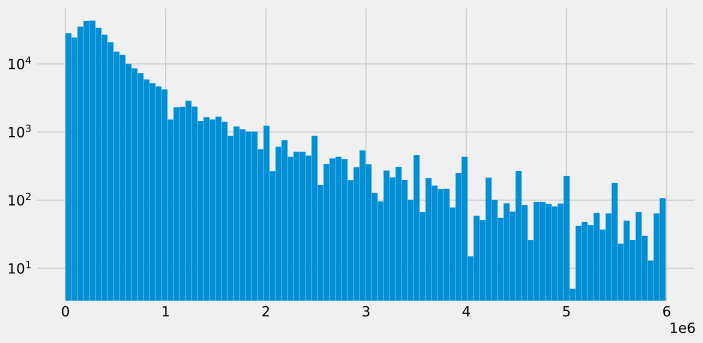

In [255]:
perc1, min_emission_limits, max_emission_limits, perc99 = get_emission_limits(data_new.target)

# data.loc[data_new.target < min_emission_limits, 'enginePower'] = int(perc1)
data_new.loc[data_new.target < perc99, 'target'].hist(figsize=(10,5), log=True,  bins=100)
target_clear = data_new.loc[data_new.target < perc99, 'target']
# data_new.target.plot()
# data_new.target.value_counts().hist(figsize=(12,5));
# sns.histplot(data=data_new[: 4], x="target")

plt.tight_layout()

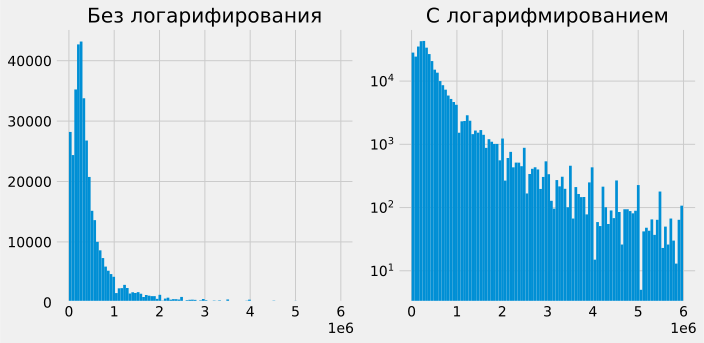

In [256]:
fig ,ax = plt.subplots(1,2,figsize=(10, 15));
ax1,ax2 = ax.flatten()
ax1.set_title('Без логарифирования')
target_clear.hist(figsize=(10,5), log=False, bins=100, ax=ax1);
ax2.set_title('С логарифмированием')
target_clear.hist(figsize=(10,5), log=True, bins=100, ax=ax2);
# display(data.mileage.value_counts(dropna=False))
plt.tight_layout()

### Результаты EDA
* Обработал данные, создал новые признаки, прологарифмировал целевую переменную
* Из-за большого количества пропусков в данных приходилось менять их на значения "NO_DATA" 
* Если останется время, можно получить дополнительную информацию о городах из внешних источников.

In [257]:
display(data_new.head(3))
data_new.info()

,status,private_pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,...,sk_gr_05,sk_gr_06,sk_gr_07,sk_gr_08,sk_gr_09,sk_gr_10,sk_gr_11,sk_gr_12,beds_num,beds_area
0,ACTIVE,False,SINGLE,240 HEATHER LN,3.5,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",1,SOUTHERN PINES,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,...,3,3,3,3,3,3,3,3,4.0,0.0
1,FOR SALE,False,SINGLE,12911 E HEROY AVE,3.0,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",0,SPOKANE VALLEY,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","1,947 SQFT",...,2,2,2,2,1,1,1,1,3.0,0.0
2,FOR SALE,False,SINGLE,2005 WESTRIDGE RD,2.0,"{'atAGlanceFacts': [{'factValue': '1961', 'fac...",1,LOS ANGELES,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...","3,000 SQFT",...,1,1,1,1,1,1,1,1,3.0,0.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 373068 entries, 0 to 376101
Data columns (total 50 columns):
 #   Column                     Non-Null Count   Dtype   
---  ------                     --------------   -----   
 0   status                     373068 non-null  category
 1   private_pool               373068 non-null  bool    
 2   propertyType               373068 non-null  category
 3   street                     373066 non-null  object  
 4   baths                      373068 non-null  float64 
 5   homeFacts                  373068 non-null  object  
 6   fireplace                  373068 non-null  int64   
 7   city                       373068 non-null  category
 8   schools                    373068 non-null  object  
 9   sqft                       333106 non-null  object  
 10  zipcode                    373068 non-null  object  
 11  beds                       282515 non-null  object  
 12  state                      373068 non-null  category
 13  stories       

In [258]:
delete_col

['MlsId',
 'mls_id',
 'private_pool',
 'PrivatePool',
 'street',
 'street',
 'hf_lotsize',
 'hf_price_sqft',
 'homeFacts',
 'schools',
 'sqft',
 'zipcode',
 'beds']

In [259]:
dataset =  data_new.drop(delete_col, axis=1)
dataset.status = dataset.status.astype('category')
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 373068 entries, 0 to 376101
Data columns (total 38 columns):
 #   Column                     Non-Null Count   Dtype   
---  ------                     --------------   -----   
 0   status                     373068 non-null  category
 1   propertyType               373068 non-null  category
 2   baths                      373068 non-null  float64 
 3   fireplace                  373068 non-null  int64   
 4   city                       373068 non-null  category
 5   state                      373068 non-null  category
 6   stories                    373068 non-null  float64 
 7   target                     373068 non-null  int32   
 8   private_pool_union         373068 non-null  bool    
 9   street_type                373068 non-null  category
 10  has_address                373068 non-null  bool    
 11  hf_built_year              373068 non-null  int64   
 12  hf_remodeled_year          373068 non-null  int64   
 13  hf_heating    

In [ ]:
dataset.dropna(inplace=True)
dataset.info()

### Код ML вынесем в отдельный блокнот